# Statistical analysis of accelerometer data
## 1. Load data

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
import pylab as pl
import random
from IPython.display import display
from scipy.fft import fft, fftfreq

In [3]:
data_path = Path("../data/dataset_000/acceleration")
n_samples = 30000

box = {
    "good": pd.read_csv(data_path/"good.csv", usecols=["time", "x_box", "y_box", "z_box"]),#, nrows=n_samples),
    "medium": pd.read_csv(data_path/"medium.csv", usecols=["time", "x_box", "y_box", "z_box"]),#, nrows=n_samples),
    "bad": pd.read_csv(data_path/"bad.csv", usecols=["time", "x_box", "y_box", "z_box"]),#, nrows=n_samples),
}

cam = {
    "good": pd.read_csv(data_path/"good.csv", usecols=["time", "x_cam", "y_cam", "z_cam"]),#, nrows=n_samples),
    "medium": pd.read_csv(data_path/"medium.csv", usecols=["time", "x_cam", "y_cam", "z_cam"]),#, nrows=n_samples),
    "bad": pd.read_csv(data_path/"bad.csv", usecols=["time", "x_cam", "y_cam", "z_cam"]),#, nrows=n_samples),
}

In [ ]:
data_path_2 = Path("../data/raw/000_220222/accelerometer.csv")
data_2 = pd.read_csv(data_path_2)

display(data_2)

in_g = data_2.iloc[99][1:4].to_list()

in_ms2 = magnitude(*in_g)
in_ms2

## 2. Transform accelerometer coordinates to bicycle coordinates

Box: -145° around x axis and 90° around z axis  
Camera: 43° around x axis and -90° around z axis

In [3]:
def Rx(theta):
    return np.array(
        [[ 1, 0              , 0              ],
         [ 0, math.cos(theta),-math.sin(theta)],
         [ 0, math.sin(theta), math.cos(theta)]]
    )
  
def Ry(theta):
    return np.array(
        [[ math.cos(theta), 0, math.sin(theta)],
         [ 0              , 1, 0              ],
         [-math.sin(theta), 0, math.cos(theta)]]
    )
  
def Rz(theta):
    return np.array(
        [[ math.cos(theta),-math.sin(theta), 0 ],
         [ math.sin(theta), math.cos(theta), 0 ],
         [ 0              , 0              , 1 ]]
    )

def magnitude(vector):
    return math.sqrt(
        pow(vector[0], 2) + pow(vector[1], 2) + pow(vector[2], 2)
    )

# box transform matrix
box_transform = Rz(np.radians(90)) @ Rx(np.radians(-145))
print(box_transform)

# cam transform matrix
cam_transform = Rz(np.radians(-90)) @ Rx(np.radians(43))
print(cam_transform)

[[ 6.12323400e-17  8.19152044e-01 -5.73576436e-01]
 [ 1.00000000e+00 -5.01585965e-17  3.51214273e-17]
 [ 0.00000000e+00 -5.73576436e-01 -8.19152044e-01]]
[[ 6.12323400e-17  7.31353702e-01 -6.81998360e-01]
 [-1.00000000e+00  4.47824985e-17 -4.17603554e-17]
 [ 0.00000000e+00  6.81998360e-01  7.31353702e-01]]


In [5]:
def box_to_bicycle(vector):
    """Apply -145° x axis rotation and 90° z axis rotation"""
    return np.array([[ 6.12323400e-17,  8.19152044e-01, -5.73576436e-01],
                     [ 1.00000000e+00, -5.01585965e-17,  3.51214273e-17],
                     [ 0.00000000e+00, -5.73576436e-01, -8.19152044e-01]]) @ vector

def cam_to_bicycle(vector):
    """Apply 43° x axis rotation and -90° z axis rotation"""
    return np.array([[ 6.12323400e-17,  7.31353702e-01, -6.81998360e-01],
                     [-1.00000000e+00,  4.47824985e-17, -4.17603554e-17],
                     [ 0.00000000e+00,  6.81998360e-01,  7.31353702e-01]]) @ vector

box_in = np.array([[0.202881], [-0.565674], [-0.818359]])
box_out = box_to_bicycle(box_in)

cam_in = np.array([[-0.047607], [0.666016], [0.740234]])
cam_out = cam_to_bicycle(cam_in)

print(box_out)
print(cam_out)

[[0.00601843]
 [0.202881  ]
 [0.99481772]]
[[-0.01774511]
 [ 0.047607  ]
 [ 0.9955947 ]]


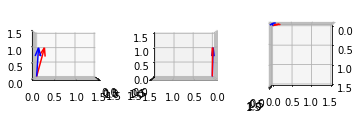

In [4]:
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection="3d"))

lim = [0, 1.5]
views = [[0, 0], [0, 90], [90, 0]]

for i, axis in enumerate(axes):
    axis.set_xlim(*lim)
    axis.set_ylim(*lim)
    axis.set_zlim(*lim)

    axis.view_init(*views[i])

    axis.quiver(0,0,0,*box_out, color="red")
    axis.quiver(0,0,0,*cam_out, color="blue")

## Transform all box data to bicycle coordinates

In [6]:
for quality in box:
    box[quality] = pd.DataFrame([(row[1], *box_to_bicycle(np.array([[row[2]], [row[3]], [row[4]]])).flat) for row in box[quality].itertuples()], columns=["time", "x_box", "y_box", "z_box"])

box["good"]

time     x_box     y_box     z_box
0       1.645526e+09 -0.012343  0.033691  0.985620
1       1.645526e+09 -0.095259  0.103027  1.041294
2       1.645526e+09  0.005678  0.028076  0.988798
3       1.645526e+09 -0.075202  0.067383  1.012050
4       1.645526e+09 -0.066958  0.052490  1.034890
...              ...       ...       ...       ...
150572  1.645527e+09 -0.059918  0.022461  1.467186
150573  1.645527e+09 -0.271008 -0.339111  1.456435
150574  1.645527e+09 -0.113879  0.157471  1.622099
150575  1.645527e+09 -0.054375  0.129883  1.490426
150576  1.645527e+09 -0.670032  0.410156  1.683379

[150577 rows x 4 columns]

In [7]:
# calculate difference of the every datapoint to previous one

box_diff = {}
for quality in box:
    box_diff[quality] = box[quality][["x_box", "y_box", "z_box"]].diff()
    box_diff[quality].insert(0, "time", box[quality]["time"])
    box_diff[quality].loc[0]["x_box", "y_box", "z_box"] = 0

box_diff["good"]

time     x_box     y_box     z_box
0       1.645526e+09  0.000000  0.000000  0.000000
1       1.645526e+09 -0.082915  0.069336  0.055674
2       1.645526e+09  0.100937 -0.074951 -0.052496
3       1.645526e+09 -0.080880  0.039307  0.023252
4       1.645526e+09  0.008244 -0.014893  0.022840
...              ...       ...       ...       ...
150572  1.645527e+09 -0.097416 -0.376465  0.342707
150573  1.645527e+09 -0.211090 -0.361572 -0.010751
150574  1.645527e+09  0.157129  0.496582  0.165665
150575  1.645527e+09  0.059504 -0.027588 -0.131673
150576  1.645527e+09 -0.615657  0.280273  0.192953

[150577 rows x 4 columns]

In [113]:
def get_random_sample(data, interval_s, blacklist=[]):
    """get a random continous interval with given length from data"""
    interval_length = 0
    random_i = -1

    while interval_length < (interval_s - 0.05) or random_i in blacklist:
        random_i = random.randint(0, data.shape[0]-1)
        random_i_time = data.iloc[random_i]["time"]
        interval = data[((random_i_time - data["time"]) <= interval_s) & ((random_i_time >= data["time"]))]
        interval_length = interval.iloc[-1]["time"] - interval.iloc[0]["time"]
    
    return random_i, interval

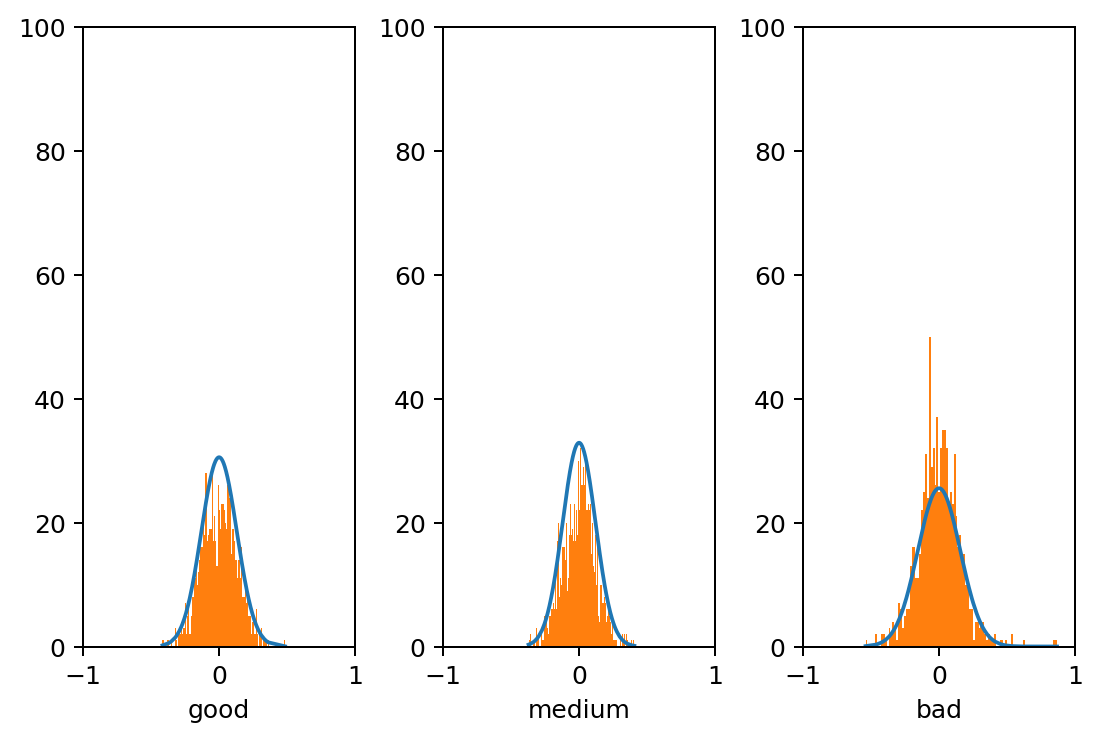

In [94]:
fig, axes = plt.subplots(1, 3)
fig.set_dpi(180)
fig.set_constrained_layout(True)

for i, axis in enumerate(axes):
    # get random sample
    quality = list(box_diff.keys())[i]
    sample = get_random_sample(box_diff[quality], 3)
    values = sorted(sample["z_box"].to_numpy())
    
    # plot distribution
    axis.set_xlim((-1, 1))
    axis.set_ylim((0, 100))
    axis.set_xlabel(quality)
    axis.plot(values, stats.norm.pdf(values, np.mean(values), np.std(values))*10)
    axis.hist(values, 100)

In [102]:
def stats(df):
    out = {}
    out["std"] = df.loc[:, df.columns!="time"].std().to_numpy()
    out["var"] = df.loc[:, df.columns!="time"].var().to_numpy()
    out["mean"] = df.loc[:, df.columns!="time"].mean().to_numpy()
    out["min"] = df.loc[:, df.columns!="time"].min().to_numpy()
    out["max"] = df.loc[:, df.columns!="time"].max().to_numpy()
    return out


interval_s = 1
samples_n = 5000
cols = ["x_std", "x_var", "x_mean", "x_min", "x_max", "y_std", "y_var", "y_mean", "y_min", "y_max", "z_std", "z_var", "z_mean", "z_min", "z_max"]

analysis_results = []

for quality in box_diff:
    data = box_diff[quality]
    
    samples = 0
    used_i = []

    results = []

    # 1000 random intervalls
    while samples < samples_n:
        random_i = random.randint(0, data.shape[0])

        # check if index used
        if random_i in used_i:
            continue
        used_i.append(random_i)

        random_i_time = data.iloc[random_i]["time"]
        interval = data[((random_i_time - data["time"]) <= interval_s) & ((random_i_time >= data["time"]))]
        
        # check interval length
        if (interval.iloc[-1]["time"] - interval.iloc[0]["time"]) < (interval_s - 0.1):
            continue

        # calculate statistical values
        result = []
        for val in stats(interval).values():
            result.extend(list(val)) 
        results.append(result)

        samples += 1

    results = pd.DataFrame(results, columns=cols)
    analysis_results.append(results.mean())
    #display(results)
    
final_results = pd.DataFrame(analysis_results).transpose()
final_results.columns = ["good", "medium", "bad"]
print("interval\t\t{}s\nsamples\t\t{}".format(interval_s, samples_n))
display(final_results)

interval		1s
samples		5000


good    medium       bad
x_std   0.218663  0.257764  0.152320
x_var   0.211960  0.247917  0.127806
x_mean  0.167665  0.185032  0.115033
x_min   0.052514  0.101083  0.029928
x_max   0.050805  0.111580  0.022719
y_std   0.032580  0.063323  0.016593
y_var  -0.000026  0.000013 -0.000002
y_mean  0.000013 -0.000024 -0.000006
y_min   0.000012 -0.000007  0.000011
y_max  -0.658436 -0.901361 -0.535476
z_std  -0.657231 -0.957792 -0.492646
z_var  -0.507148 -0.666412 -0.439041
z_mean  0.643351  0.920128  0.512043
z_min   0.643346  0.900527  0.463038
z_max   0.514297  0.703056  0.468693

## Fourier analysis

In [1]:
ax = ["x", "y", "z"]
fig, axes = plt.subplots(len(ax), 3, figsize=(9, 3*len(ax)), dpi=180, constrained_layout=True, sharey=True)

accelerometer = "box"
interval_s = 1
n_samples = 1

fig.suptitle("{} {} accelerometer samples of length {}s".format(n_samples, accelerometer, interval_s), fontsize="xx-large")
colors = ["green", "orange", "red"]

for j, axis in enumerate(ax):
    for k, quality in enumerate(locals()[accelerometer].keys()):
        data = locals()[accelerometer][quality]
        
        used_i = []
        sample_rates = []
        ffts = []

        # n random intervalls
        for n in range(n_samples):
            sample_i, sample = get_random_sample(locals()[accelerometer][quality], interval_s, used_i)
            used_i.append(sample_i)

            values = sample[axis+"_"+accelerometer].to_numpy()

            sample_rate = 1/(sample["time"].diff().mean())
            sample_rates.append(sample_rate)
            
            yf = fft(values)
            ffts.append(np.abs(yf[:100]))

        if len(ax) == 1:
            fig_ax = axes[k]
        else:
            fig_ax = axes[j][k]

        fig_ax.set_title("{}".format(quality))
        fig_ax.set_xlim((0, 100))
        fig_ax.set_ylim((0, 25))
        fig_ax.set_xlabel("[in Hz]")
        if k == 0:
            fig_ax.set_ylabel(axis+" axis")

        xf = fftfreq(300, 1/300)[:100]
        yf = np.mean(np.array(ffts), axis=0)
        fig_ax.plot(xf, yf, color=colors[k])

# for i, axis in enumerate(axes):
#     # get random sample
#     quality = list(box.keys())[i]
#     sample = get_random_sample(box[quality], 1)
#     values = sample["z_box"].to_numpy()

#     sample_rate = 1/(sample["time"].diff().mean())
#     n_half = int(len(values)/2)
    
#     #axis.set_xlim((0, 0.001))
#     axis.set_ylim((0, 100))
#     axis.set_xlabel("{}\n[in Hz]".format(quality))
    
#     yf = fft(values)
#     xf = fftfreq(len(values), 1/sample_rate)

#     axis.plot(xf[:n_half], np.abs(yf[:n_half]))

NameError: name 'plt' is not defined